In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import os
import pickle
import json

from tqdm import tqdm_notebook

In [2]:
#path_dataset = '../input/'
path_dataset = '/home/edoardobucheli/Datasets/FSDKaggle2018'

path_train = os.path.join(path_dataset,'audio_train_16k')
path_test = os.path.join(path_dataset,'audio_test_16k')

### Load Label Data

In [3]:
train_data = pd.read_csv(os.path.join(path_dataset,'train_post_competition.csv'))
test_data = pd.read_csv(os.path.join(path_dataset,'test_post_competition_scoring_clips.csv'))

In [4]:
from utilities import get_all_classes_dict, get_classes_to_meta_dict, get_labels

In [5]:
num_to_label, label_to_num, n_classes = get_all_classes_dict(train_data)
label_to_meta, label_num_to_meta = get_classes_to_meta_dict(label_to_num)

In [6]:
data_cur = train_data[train_data['manually_verified']==1]
data_noi = train_data[train_data['manually_verified']==0]

In [7]:
meta_labels_all, labels_all = get_labels(train_data,label_to_meta, label_to_num)
meta_labels_cur, labels_cur = get_labels(data_cur,label_to_meta, label_to_num)
meta_labels_noi, labels_noi = get_labels(data_noi,label_to_meta, label_to_num)
meta_labels_test, labels_test = get_labels(test_data,label_to_meta, label_to_num)

In [8]:
n_meta_classes = len(np.unique(meta_labels_all))

In [9]:
is_curated = train_data['manually_verified'].tolist()
indx_curated = [i for i,f in enumerate(is_curated) if f == 1]

### Load Data

In [10]:
pickle_train = './preprocessed_train/MS-80-HL512-WF16k-64k'
pickle_test = './preprocessed_test/MS-80-HL512-WF16k-64k'

In [11]:
with open(pickle_train,'rb') as fp:
    x_train = pickle.load(fp)
with open(pickle_test, 'rb') as fp:
    x_test = pickle.load(fp)

### Separate Curated and MC

In [12]:
x_cur = [x_train[f] for f in indx_curated]

In [13]:
indx_0 = [i for i,f in enumerate(meta_labels_cur) if f == 0]

In [14]:
x_0 = [x_cur[f] for f in indx_0]
labels_0 = [labels_cur[f] for f in indx_0]
labels_name_0 = [num_to_label[f] for f in labels_0]

c0_new_label_mapping = dict([[f,i] for i,f in enumerate(np.unique(labels_0))])
new_train_labels_0 = [c0_new_label_mapping[f] for f in labels_0]

In [15]:
indx_unk = [i for i in np.random.randint(0,len(x_cur),len(x_0))if i not in indx_0]
x_unk = [x_cur[f] for f in indx_unk]
labels_unk = np.ones((len(indx_unk),))*(len(np.unique(new_train_labels_0)))

In [16]:
x_0_2 = x_0 + x_unk
new_train_labels_0.extend(labels_unk)

In [17]:
#with open('./c0_mapping','wb') as fp:
#    pickle.dump(c0_new_label_mapping,fp)

In [18]:
indx_test_0 = [i for i,f in enumerate(meta_labels_test) if f == 0]

In [19]:
x_test_0 = [x_test[f] for f in indx_test_0]
labels_test_0 = [labels_test[f] for f in indx_test_0]
new_test_labels_0 = [c0_new_label_mapping[f] for f in labels_test_0]

In [20]:
indx_unk_test = [i for i in np.random.randint(0,len(x_test),len(x_test_0)) if i not in indx_test_0]
x_unk_test = [x_test[f] for f in indx_unk_test]
labels_unk_test = np.ones((len(indx_unk_test),))*(len(np.unique(new_test_labels_0)))

In [21]:
x_test_0_2 = x_test_0+x_unk_test
new_test_labels_0.extend(labels_unk_test)

In [22]:
sr = 16000
file_length = sr*4
hop_length = 512
n_mels = 80

frames = int(np.ceil(file_length/hop_length))

In [23]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self,x_set,y_set,
                 batch_size = 128,input_shape = (80,frames),
                 n_classes=80, sr = 44100, seconds = 4):
        
        self.x, self.y = x_set,y_set
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.sr = sr
        self.file_length = sr*seconds
        #self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.x)/self.batch_size))
    
    def __getitem__(self,idx):
        
        spects = self.x[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
        
        batch_x = self.__generate_data(spects)
        
        #print(batch_x.shape)
        #print(batch_y.shape)
        
        return batch_x,batch_y
    
    def __generate_data(self,spects):
        n_mels,frames = self.input_shape
        x_batch = np.zeros((len(spects),n_mels,frames))
        
        for i, spect in enumerate(spects):
            freq_res,time_res = spect.shape
            
            max_start = time_res-frames
            if max_start == 0:
                start = 0
            else:
                start = np.random.randint(0,max_start)
            end = start+frames
            
            x_batch[i] = spect[:,start:end]
        
        return x_batch

# Malley CNN

In [24]:
from CNNetworks2D import malley_cnn_80
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [25]:
input_shape = ([n_mels,frames])
lr = 0.001
model = malley_cnn_80(input_shape,41)
model.load_weights('./weights_m41.h5')
#model.summary()

In [27]:
new_output_name = 'global_max_pooling2d'
new_output_layer = model.get_layer(new_output_name).output
model_headless = tf.keras.Model(inputs = model.input, outputs = new_output_layer)

In [29]:
model_headless.trainable = False

In [33]:
X = tf.keras.layers.Dense(512,activation='relu')(model_headless.output)
X = tf.keras.layers.Dropout(0.5)(X)
X = tf.keras.layers.Dense(8, activation = 'softmax')(X)

In [34]:
model = tf.keras.Model(inputs = model_headless.input, outputs = X)

In [36]:
for l in model.layers[:13]:
    l.trainable = False

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 125)           0         
_________________________________________________________________
expand_dims (Lambda)         (None, 80, 125, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 125, 64)       1408      
_________________________________________________________________
activation (Activation)      (None, 80, 125, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 125, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 125, 128)      57472     
_________________________________________________________________
activation_1 (Activation)    (None, 40, 125, 128)      0         
__________

In [39]:
model.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

### Split Dataset and make Generators

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
#X_train_n,X_val_n,y_train_n,y_val_n = train_test_split(X_noisy,y_noisy,test_size=0.1, random_state=7)

In [37]:
X_train_a,X_val_a,y_train_a,y_val_a = train_test_split(x_0_2,new_train_labels_0,
                                                       test_size=0.1, random_state=7, shuffle= True)

In [38]:
#train_generator_n = DataGenerator(X_train_n,y_train_n)
#val_generator_n = DataGenerator(X_val_n,y_val_n)

In [39]:
train_generator_a = DataGenerator(X_train_a,y_train_a)
val_generator_a = DataGenerator(x_test_0_2,new_test_labels_0)

### Train the Model

In [40]:
malley2.fit_generator(train_generator_a,epochs = 20,validation_data=val_generator_a)

Epoch 1/20
12/12 [==============================] - 2s 207ms/step - loss: 1.6441 - acc: 0.5056 - val_loss: 0.6526 - val_acc: 0.8109
Epoch 2/20
12/12 [==============================] - 1s 97ms/step - loss: 0.4338 - acc: 0.8618 - val_loss: 0.5798 - val_acc: 0.8331
Epoch 3/20
12/12 [==============================] - 1s 94ms/step - loss: 0.2408 - acc: 0.9227 - val_loss: 0.5599 - val_acc: 0.8419
Epoch 4/20
12/12 [==============================] - 1s 94ms/step - loss: 0.1960 - acc: 0.9430 - val_loss: 0.5705 - val_acc: 0.8449
Epoch 5/20
12/12 [==============================] - 1s 95ms/step - loss: 0.1394 - acc: 0.9575 - val_loss: 0.5692 - val_acc: 0.8493
Epoch 6/20
12/12 [==============================] - 1s 95ms/step - loss: 0.1204 - acc: 0.9600 - val_loss: 0.5471 - val_acc: 0.8567
Epoch 7/20
12/12 [==============================] - 1s 95ms/step - loss: 0.1023 - acc: 0.9705 - val_loss: 0.6047 - val_acc: 0.8464
Epoch 8/20
12/12 [==============================] - 1s 97ms/step - loss: 0.0756 - 

In [41]:
x_test_c0 = np.zeros((len(x_test_0_2),80,125))

for i, this_x in enumerate(x_test_0_2):
    
    this_frames = this_x.shape[1]
    
    if this_frames > 125:
        max_start = this_frames - 125
        start = np.random.randint(0,max_start)
        end = start+125

        this_x = this_x[:,start:end]
        
    x_test_c0[i] = this_x

In [42]:
malley2.evaluate(x_test_c0,new_test_labels_0)

677/677 [==============================] - 1s 827us/step


[0.6710877177502239, 0.8611521418020679]

In [43]:
y_scores = malley2.predict(x_test_c0)

In [44]:
y_hat_c0 = np.argmax(y_scores, axis = 1)

### Plot Confussion Matrix

In [45]:
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [46]:
cm = confusion_matrix(new_test_labels_0,y_hat_c0)

In [47]:
c0_to_name = {0:'Clarinet',1:'Flute',2:'Harmonica',3:'Oboe',4:'Saxophone',5:'Telephone',6:'Trumpet'}

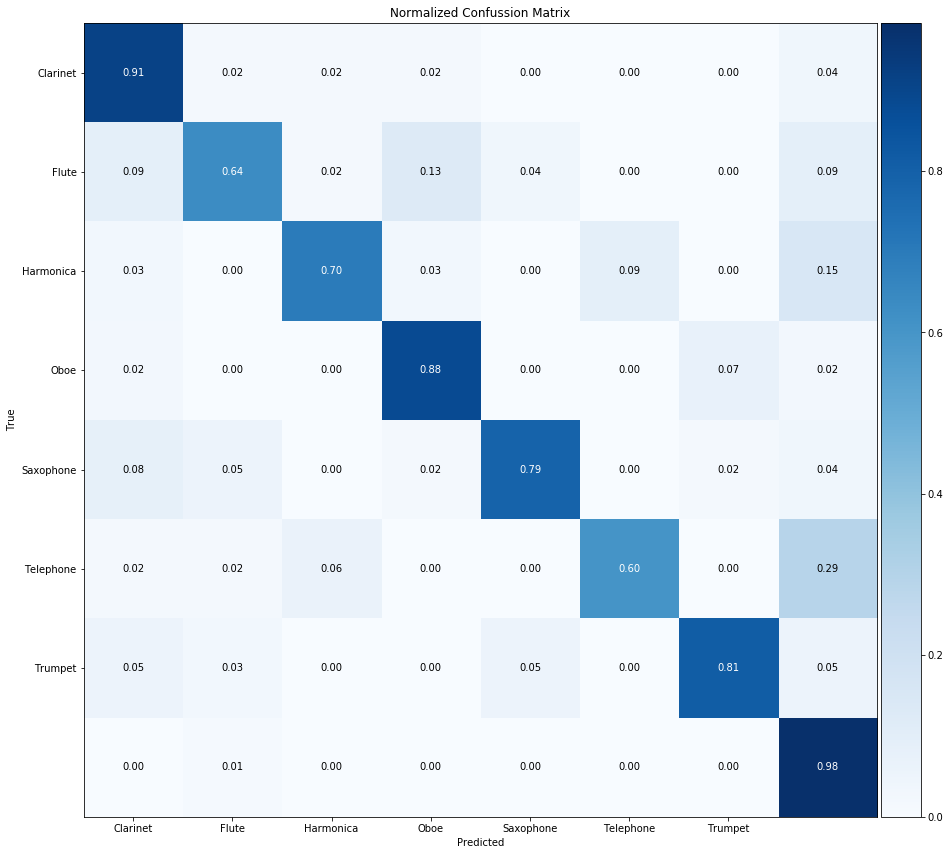

In [48]:
normalize = True


fig, ax = plt.subplots(1,1,figsize = (15,15))

if normalize:
    ax.set_title('Normalized Confussion Matrix')
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

im1 = ax.imshow(cm, cmap = plt.cm.Blues)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im1, cax=cax)

fig = ax.set(xlabel = 'Predicted', ylabel = 'True')
fig = ax.set_xticks(np.arange(7))
fig = ax.set_xticklabels(c0_to_name.values())

fig = ax.set_yticks(np.arange(7))
fig = ax.set_yticklabels(c0_to_name.values())

fmt = '.2f' if normalize else 'd'

#fmt = 'd'
thresh = cm.max() / 2.

for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

In [51]:
malley2.save_weights('./weights_c0_malley_v2.h5')
malley2.save('./model_c0_malley_pretrained.h5')